In [160]:
import sys
from os import path
import json

import torch
from ipypb import ipb
# import numpy
import multiprocess as mp
from joblib import Parallel, delayed

from networks import *
from data import *
from utils import *
from mol_spec import *
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
import dgl

In [161]:
device='cpu'
config_id='naive3'
device='cpu'
c_file='data-center/scaffolds_c.smi'
file='data-center/scaffolds_a.smi'
scaffold_idx=333333
model_idx=3
num_gen=20
np=mp.cpu_count()
mode='all'

In [162]:
model_ckpt = f'ckpt/{config_id}/model_{model_idx}.ckpt'

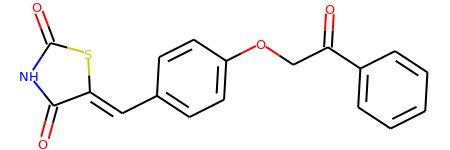

In [165]:
Chem.MolFromSmiles(str_from_line(file, scaffold_idx))

In [166]:
model = torch.load(model_ckpt, map_location=device).eval()

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'networks.GraphInf' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [167]:
c_smiles = str_from_line(c_file, scaffold_idx)
smiles = str_from_line(file, scaffold_idx)

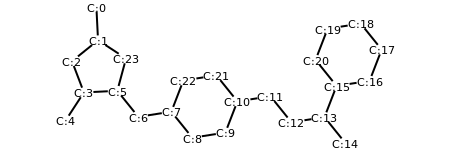

In [168]:
Chem.MolFromSmiles(c_smiles)

In [169]:
g, cg = smiles_to_dgl_graph(smiles)
whole_g, whole_cg = graph_to_whole_graph(g), graph_to_whole_graph(cg)

In [170]:
num_N = whole_cg.number_of_nodes()
num_E = whole_cg.number_of_edges()
adj = whole_cg.adjacency_matrix().coalesce()
indices = torch.cat(
    [adj.indices(), torch.arange(0, num_N).repeat(2, 1)],
    dim=-1
)
values = torch.ones(num_E + num_N)
s_adj = torch.sparse_coo_tensor(
    indices,
    values,
    torch.Size([num_N, num_N])
)
c_nfeat = whole_cg.ndata['feat'].to(device)
c_nfeat = onehot_to_label(c_nfeat)

In [171]:
x_inf = model.inf(c_nfeat, s_adj).cpu().detach()

In [180]:
import importlib
import utils

utils = importlib.reload(utils)

a = utils.get_mols_from_array(x_inf, smiles, num_gen, sanitize=False)

In [181]:
a

RDKit ERROR: [00:27:39] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: getExplicitValence() called without call to calcExplicitValence()
RDKit ERROR: Violation occurred on line 161 in file /opt/conda/conda-bld/rdkit_1561471048963/work/Code/GraphMol/Atom.cpp
RDKit ERROR: Failed Expression: d_explicitValence > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [00:27:45] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: getExplicitValence() called without call to calcExplicitValence()
RDKit ERROR: Violation occurred on line 161 in file /opt/conda/conda-bld/rdkit_1561471048963/work/Code/GraphMol/Atom.cpp
RDKit ERROR: Failed Expression: d_explicitValence > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [00:27:52] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: getExplicitValence() called without call to calcExplicitValence()
RDKit ERROR: Violation occurred on line 161 in file /opt/conda/co

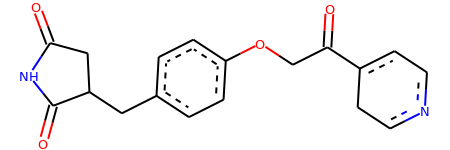

In [185]:
a[4]

In [157]:
for b in a[10].GetBonds():
    print(b.GetBondType())

AROMATIC
AROMATIC
AROMATIC
SINGLE
SINGLE
SINGLE
AROMATIC
AROMATIC
AROMATIC
SINGLE
SINGLE
SINGLE
SINGLE
AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
SINGLE


In [122]:
Draw.MolsToGridImage(a,molsPerRow=5,subImgSize=(200,200))


RDKit ERROR: [22:53:10] Can't kekulize mol.  Unkekulized atoms: 13 14 15
RDKit ERROR: 


ValueError: Sanitization error: Can't kekulize mol.  Unkekulized atoms: 13 14 15


In [69]:
m = Chem.MolFromSmiles(str_from_line('data-center/scaffolds_c.smi', 4444))

In [65]:
get_num_lines('data-center/scaffolds_a.smi')

338903

In [68]:
str_from_line('data-center/scaffolds_c.smi', 4444)

'[CH3:0][CH:1]([CH2:2][CH2:3][CH:4]1[CH2:5][CH2:6][CH2:7][CH2:8][CH2:9]1)[CH2:10][CH2:11][CH:12]1[CH2:13][CH2:14][CH:15]([CH2:16][CH:17]2[CH2:18][CH2:19][CH2:20][CH2:21][CH2:22]2)[CH2:23][CH2:24]1'

In [71]:
m = Chem.RemoveHs(m)

In [72]:
for atom in m.GetAtoms():
    print(atom.GetNumExplicitHs())

3
1
2
2
1
2
2
2
2
2
2
2
1
2
2
1
2
1
2
2
2
2
2
2
2


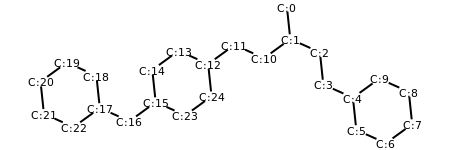

In [73]:
m